In [1]:
import numpy as np
import pandas as pd
import re,os,time, math
from shutil import copyfile
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

In [9]:
raw_df = pd.read_csv('/home/timhu/data/India_pov_pop_May17.csv')

## initial cleanup

In [3]:
raw_df.loc[:,raw_df.columns != 'CENSUS2011'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,568006.00,284001.89,163967.97,1.00,142002.25,284000.50,426001.75,568002.00
state_id,568006.00,16.92,8.53,1.00,9.00,19.00,23.00,35.00
secc_hh,568006.00,281.45,410.55,1.00,75.00,167.00,337.00,13333.00
secc_pop,568006.00,1393.75,1939.19,1.00,370.00,837.00,1702.00,61582.00
secc_pop_scaled,568006.00,1224.05,1707.63,0.75,325.35,734.95,1494.85,54504.45
secc_cons,567980.00,23432440.20,37969324.46,23203.48,5547085.28,12983540.42,27560439.46,1747434604.04
secc_pov_rate,567980.00,0.20,0.17,0.00,0.07,0.17,0.30,1.00
secc_pov_rate_tend,567980.00,0.14,0.13,0.00,0.03,0.10,0.20,1.00
secc_cons_per_hh,567980.00,81408.75,24569.78,156.74,63922.50,79304.40,94753.18,282054.66
secc_cons_per_cap,567980.00,16686.70,6538.26,27.56,12732.68,15425.28,19297.24,247666.09


In [12]:
# duplications in village_id
raw_df[raw_df.duplicated(['id'], keep=False).values]

,id,state_id,secc_hh,secc_pop,secc_pop_scaled,secc_cons,secc_pov_rate,secc_pov_rate_tend,secc_cons_per_hh,secc_cons_per_cap,secc_cons_per_cap_scaled,pc11_hh,pc11_pop,pc11_cons,area,longitude,latitude,district_id,subdistrict_id
265426,265427,19,126,594,521.70,7132345.71,0.38,0.26,56605.92,12007.32,13671.35,119,556,6736104.00,2433560.00,88.28,26.77,327,2160
265427,265427,19,126,594,521.70,7132345.71,0.38,0.26,56605.92,12007.32,13671.35,119,556,6736104.00,2433560.00,88.28,26.77,327,2163
276079,276079,19,243,1126,1001.10,15048051.91,0.42,0.27,61926.14,13364.17,15031.52,245,1127,15171904.00,1660272.15,87.49,23.70,334,2265
276080,276079,19,243,1126,1001.10,15048051.91,0.42,0.27,61926.14,13364.17,15031.52,245,1127,15171904.00,1660272.15,87.49,23.70,334,2266
276081,276080,19,243,1126,1001.10,15048051.91,0.42,0.27,61926.14,13364.17,15031.52,245,1127,15171904.00,1131173.72,87.49,23.68,334,2265
276082,276080,19,243,1126,1001.10,15048051.91,0.42,0.27,61926.14,13364.17,15031.52,245,1127,15171904.00,1131173.72,87.49,23.68,334,2266
539884,539882,29,560,2265,2028.75,61220080.52,0.02,0.02,109321.57,27028.73,30176.26,750,3015,81991176.00,2641220.10,77.64,12.85,572,5542
539885,539882,29,560,2265,2028.75,61220080.52,0.02,0.02,109321.57,27028.73,30176.26,750,3015,81991176.00,2641220.10,77.64,12.85,572,5543


In [5]:
df = raw_df[['id','state_id','district_id', 'subdistrict_id', 'secc_pop','secc_pop_scaled','area','longitude','latitude']].copy()
# # remove all rows with duplicated value in village_id column
# df = df[~df.duplicated(['village_id'], keep=False).values]
# remove other rows with duplications in all columns, but keep one row
df = df.drop_duplicates(keep = 'first')
# # remove 'village_id' column
# df.drop('village_id', axis=1, inplace=True)
df.rename(columns={'id':'village_id'}, inplace=True)
df.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude
568001,567998,35,640,5924,69,62.30,nan,nan,nan
568002,567999,35,640,5924,201,181.00,nan,nan,nan
568003,568000,35,640,5924,145,129.90,nan,nan,nan
568004,568001,35,640,5924,173,154.80,nan,nan,nan
568005,568002,35,640,5924,62,57.50,nan,nan,nan


In [6]:
# remove rows with missing area/lat/long
df = df[df.area.notnull() & df.longitude.notnull() & df.latitude.notnull()].copy()
df.index = range(len(df))
df.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude
564550,567631,34,637,5915,6737,6049.45,4667679.81,79.79,10.92
564551,567632,34,637,5915,2260,2035.50,4514581.48,79.76,10.92
564552,567633,34,637,5915,3942,3527.60,5891136.02,79.74,10.93
564553,567634,34,637,5915,2521,2269.20,3121376.70,79.77,10.92
564554,567635,34,637,5915,3197,2873.10,4717539.22,79.79,10.91


## calculate density

In [295]:
# # adjusted the mistake from area conversion mistake.
# df['area'] = df.area * 1e4

In [9]:
# area in units of m2, calculate density as nums/km2
df['pop_density'] = df.secc_pop / (df.area / 10**6)
df['pop_density_log2'] = np.log2(df['pop_density'])
df.sort_values(by='pop_density', ascending=True).head()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2
119594,120007,9,151,792,1,1.00,194013437.59,80.28,28.60,0.01,-7.60
405552,408521,23,433,3492,1,1.00,122243595.08,75.77,24.71,0.01,-6.93
77960,78373,8,114,574,5,5.00,262882274.22,71.40,27.28,0.02,-5.72
10959,11187,2,25,116,1,1.00,51600612.59,78.34,32.08,0.02,-5.69
404671,407640,23,431,3484,1,1.00,40643229.81,81.11,23.57,0.02,-5.34


In [10]:
df.sort_values(by='pop_density', ascending=False).head()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2
206070,206483,10,222,1312,837,727.30,2392.20,86.05,25.43,349887.40,18.42
207404,207817,10,225,1345,354,311.00,1089.61,86.69,25.08,324886.28,18.31
338071,340972,21,377,2899,6540,5800.10,29983.56,86.98,21.49,218119.55,17.73
256792,259695,18,317,2103,3417,2938.00,15971.95,92.29,24.74,213937.58,17.71
206008,206421,10,222,1311,20200,17534.00,105617.48,85.98,25.48,191256.23,17.55


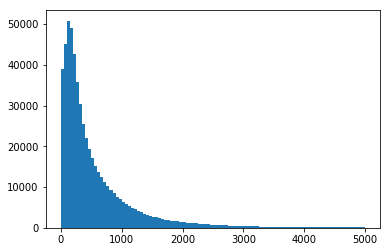

In [11]:
# distribution of density
n, bins, patches = plt.hist(df.pop_density.values, bins=100, range=(0,5000))

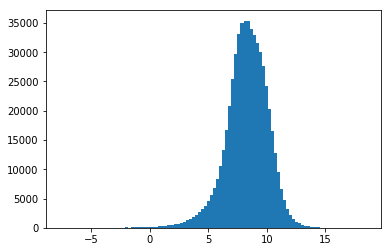

In [12]:
# distribution of log2 density
n, bins, patches = plt.hist(df.pop_density_log2.values, bins=100)

In [13]:
df.groupby('state_id')['pop_density', 'pop_density_log2'].agg([np.min, np.median, np.max, 'count'])

pop_density                          pop_density_log2               \
                amin  median      amax  count             amin median  amax   
state_id                                                                      
1               1.11  452.09  36291.87   6076             0.15   8.82 15.15   
2               0.02  235.60  34028.67  17597            -5.69   7.88 15.05   
3               0.25  346.98  22994.08  12152            -1.99   8.44 14.49   
4             993.52 2357.44   3786.44      5             9.96  11.20 11.89   
5               0.04  194.45  48207.64  14868            -4.74   7.60 15.56   
6               0.07  411.70  14474.98   6570            -3.92   8.69 13.82   
7              44.22  756.18 155428.06    106             5.47   9.56 17.25   
8               0.02  191.46  39520.76  41800            -5.72   7.58 15.27   
9               0.01  762.06  89057.66  92810            -7.60   9.57 16.44   
10              0.18 1144.06 349887.40  31786            -2.50  10.16 18.42   
11              0.05  246.39   4602.32    424            -4.40   7.94 12.17   
12              0.03   30.35   7237.49   4370            -4.95   4.92 12.82   
13              0.50   79.97  48948.16   1333            -1.01   6.32 15.58   
14              0.55  104.24  83776.15   2376            -0.87   6.70 16.35   
15              0.17   31.86   1058.19    463            -2.54   4.99 10.05   
16              4.89  323.78   6853.07    862             2.29   8.34 12.74   
17              0.21  135.29  21752.09   5598            -2.27   7.08 14.41   
18              0.37  479.97 213937.58  23091            -1.42   8.91 17.71   
19              0.24  758.68 117285.23  36435            -2.09   9.57 16.84   
20              0.28  340.47 129926.88  27391            -1.81   8.41 16.99   
21              0.10  306.22 218119.55  45963            -3.29   8.26 17.73   
22              0.29  221.32  92214.64  17932            -1.77   7.79 16.49   
23              0.01  185.36  50570.53  49079            -6.93   7.53 15.63   
24              0.03  230.36  22740.94  17813            -4.84   7.85 14.47   
26             56.56  357.07   2091.63     64             5.82   8.48 11.03   
27              0.05  196.77  60847.97  39822            -4.47   7.62 15.89   
28              0.05  222.63  31471.51  25633            -4.40   7.80 14.94   
29              0.07  205.45  20620.58  25869            -3.77   7.68 14.33   
30              0.11  205.55   4136.73    320            -3.13   7.68 12.01   
32              1.88  839.23   5949.54   1013             0.91   9.71 12.54   
33              0.17  377.02  37285.53  14845            -2.52   8.56 15.19   
34            259.73  938.18   3190.26     89             8.02   9.87 11.64   

                 
          count  
state_id         
1          6076  
2         17597  
3         12152  
4             5  
5         14868  
6          6570  
7           106  
8         41800  
9         92810  
10        31786  
11          424  
12         4370  
13         1333  
14         2376  
15          463  
16          862  
17         5598  
18        23091  
19        36435  
20        27391  
21        45963  
22        17932  
23        49079  
24        17813  
26           64  
27        39822  
28        25633  
29        25869  
30          320  
32         1013  
33        14845  
34           89

In [14]:
df.to_csv('/home/timhu/data/India_pov_pop_May17_density.csv')

## village area distribution 

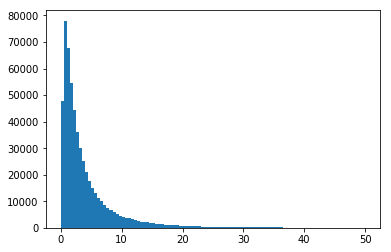

In [15]:
# distribution areas in km2
n, bins, patches = plt.hist(df.area.values / (10**6), bins=100, range=(0, 50))

In [16]:
print('median area (km2):', np.median(df.area.values) / (10**6))
print('mean area (km2):', np.mean(df.area.values) / (10**6))
print('95% percentile area (km2):', np.percentile(df.area.values, 95) / (10**6))
print('99% percentile area (km2):', np.percentile(df.area.values, 99) / (10**6))

median area (km2): 2.37460607655
mean area (km2): 4.35364674505
95% percentile area (km2): 14.3810221271
99% percentile area (km2): 29.2077693822


- the raw landsat inputs are 500x500 images with resolution 30m => covered area = 15km x 15km = 225 km2
- VGG cropped input are 224x224 images => covered area = (224 x 30 / 1000)^2 = 45.2 km2
- resize input 150x150 images => covered area = (150 x 30 / 1000)^2 = 20.25km2

## train/val/test partition without image overlap

In [2]:
df = pd.read_csv('/home/timhu/data/India_pov_pop_May17_density.csv')

In [3]:
# check the distinct numbers of states, districts, subdistricts
print('number of states:', len(df.state_id.unique()),
      'number of districts:', len(df.district_id.unique()),
      'number of subdistricts:', len(df.subdistrict_id.unique()))

# check whether each district_id is exclusively in one state_id, and also true for subdistrict_id and district_id
df_districts = df.groupby('district_id')['state_id'].agg([np.min, np.max])
print('districts that are in multiple states:', len(df_districts[(df_districts.amax - df_districts.amin) > 0]))
df_subdistricts = df.groupby('subdistrict_id')['district_id'].agg([np.min, np.max])
print('subdistricts that are in multiple districts:', len(df_subdistricts[(df_subdistricts.amax - df_subdistricts.amin) > 0]))

number of states: 32 number of districts: 619 number of subdistricts: 5724
districts that are in multiple states: 0
subdistricts that are in multiple districts: 32


In [4]:
# assign train/val/test split by stratification on subdistrict_id
# train 70% train, 20% Val, 10% test
np.random.seed(66)
all_sub_ids = df.subdistrict_id.unique()
val_test_ids = np.random.choice(all_sub_ids, int(0.3 * len(all_sub_ids)), replace=False)
test_ids = np.random.choice(val_test_ids, int(0.1 * len(all_sub_ids)), replace=False)
print('train/val/test subdistrict ids:')
print(len(all_sub_ids) - len(val_test_ids), len(val_test_ids) - len(test_ids), len(test_ids))

# assign the split as a new column 'partition'
df['partition'] = 'train'
df.loc[df.subdistrict_id.isin(val_test_ids),'partition'] = 'val'
df.loc[df.subdistrict_id.isin(test_ids),'partition'] = 'test'
print('train/val/test village ids:')
print(len(df[df.partition == 'train']), len(df[df.partition == 'val']), len(df[df.partition == 'test']))
# make sure the random seed works
np.random.rand(4)

train/val/test subdistrict ids:
4007 1145 572
train/val/test village ids:
393780 112416 58359


array([ 0.91146167,  0.27478055,  0.50450077,  0.0365537 ])

In [19]:
# the traning l8/s1 images covered area is 4.5 x 4.5 = 20.25km2
# define the the images are overlaped if the distance of their centers are shorter than 2.25
OVERLAP_DISTANCE = 2.25

# calculate the distance from 2 latitude and longitude coordinates
def distance(lat1, lon1, lat2, lon2):
    # radius of earch
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

In [20]:
%%time
# remove training partition rows that have overlap with any val/test rows
# due to large computation, only consider subdistrict boundary overlap whithin one district
# it takes really long time!! ~4.5 hours
remove_ids = []
for did in df.district_id.unique():
    df_dis = df.loc[df.district_id == did]
    count = 0
    for i1, row_train in df_dis[df_dis.partition == 'train'].iterrows():
        for i2, row_vt in df_dis[df_dis.partition != 'train'].iterrows():
            lat1, lon1, lat2, lon2 =  row_train.latitude, row_train.longitude, row_vt.latitude, row_vt.longitude
            if distance(lat1, lon1, lat2, lon2) < OVERLAP_DISTANCE:
                remove_ids.append(row_train.village_id)
                count += 1
                break
    print('district %d removes %d/%d overlap village ids' % (did, count, len(df_dis)))

district 1 removes 0/338 overlap village ids
district 2 removes 0/459 overlap village ids
district 3 removes 0/23 overlap village ids
district 4 removes 0/72 overlap village ids
district 5 removes 11/170 overlap village ids
district 6 removes 6/373 overlap village ids
district 7 removes 1/488 overlap village ids
district 8 removes 19/459 overlap village ids
district 9 removes 0/117 overlap village ids
district 10 removes 0/11 overlap village ids
district 11 removes 0/112 overlap village ids
district 12 removes 22/318 overlap village ids
district 13 removes 0/220 overlap village ids
district 14 removes 37/335 overlap village ids
district 15 removes 11/226 overlap village ids
district 16 removes 17/398 overlap village ids
district 17 removes 0/126 overlap village ids
district 18 removes 0/155 overlap village ids
district 19 removes 4/324 overlap village ids
district 20 removes 0/247 overlap village ids
district 21 removes 30/768 overlap village ids
district 22 removes 0/337 overlap villa

district 178 removes 69/1604 overlap village ids
district 179 removes 79/2354 overlap village ids
district 180 removes 56/1331 overlap village ids
district 181 removes 17/488 overlap village ids
district 182 removes 44/909 overlap village ids
district 183 removes 38/1712 overlap village ids
district 184 removes 78/2018 overlap village ids
district 185 removes 133/2787 overlap village ids
district 186 removes 0/1431 overlap village ids
district 187 removes 55/1098 overlap village ids
district 188 removes 117/2704 overlap village ids
district 189 removes 70/1382 overlap village ids
district 190 removes 109/1809 overlap village ids
district 191 removes 79/3482 overlap village ids
district 192 removes 88/1412 overlap village ids
district 193 removes 83/1742 overlap village ids
district 194 removes 51/2902 overlap village ids
district 195 removes 63/2542 overlap village ids
district 196 removes 28/1292 overlap village ids
district 197 removes 0/1102 overlap village ids
district 198 removes 

district 355 removes 30/592 overlap village ids
district 356 removes 26/348 overlap village ids
district 357 removes 97/1481 overlap village ids
district 358 removes 121/1653 overlap village ids
district 359 removes 11/725 overlap village ids
district 360 removes 39/1153 overlap village ids
district 361 removes 2/298 overlap village ids
district 362 removes 39/2314 overlap village ids
district 363 removes 0/996 overlap village ids
district 364 removes 83/1260 overlap village ids
district 365 removes 16/725 overlap village ids
district 366 removes 24/918 overlap village ids
district 367 removes 0/439 overlap village ids
district 368 removes 74/1609 overlap village ids
district 369 removes 47/1090 overlap village ids
district 370 removes 47/1153 overlap village ids
district 371 removes 10/342 overlap village ids
district 372 removes 39/1207 overlap village ids
district 373 removes 18/688 overlap village ids
district 374 removes 77/1694 overlap village ids
district 375 removes 77/2005 ove

district 529 removes 18/733 overlap village ids
district 530 removes 23/1189 overlap village ids
district 531 removes 8/715 overlap village ids
district 532 removes 26/1585 overlap village ids
district 533 removes 20/845 overlap village ids
district 534 removes 23/1036 overlap village ids
district 535 removes 42/1197 overlap village ids
district 537 removes 20/813 overlap village ids
district 538 removes 37/1465 overlap village ids
district 539 removes 8/1107 overlap village ids
district 540 removes 13/958 overlap village ids
district 541 removes 14/804 overlap village ids
district 542 removes 178/1694 overlap village ids
district 543 removes 77/1443 overlap village ids
district 544 removes 77/2806 overlap village ids
district 545 removes 61/1280 overlap village ids
district 546 removes 51/839 overlap village ids
district 547 removes 26/934 overlap village ids
district 548 removes 10/691 overlap village ids
district 549 removes 14/984 overlap village ids
district 550 removes 23/1088 ov

In [21]:
print('total overlaping villages removed:', len(set(remove_ids)))
df = df[~df.village_id.isin(remove_ids)]

total overlaping villages removed: 20217


In [22]:
df.to_csv('/home/timhu/data/India_pov_pop_May17_partiton.csv')

## add tif imge path


In [5]:
df = pd.read_csv('/home/timhu/data/India_pov_pop_May17_partiton.csv', index_col=0)

In [8]:
print(len(set(df.village_id.values)), len(df))


544334 544338


In [14]:
# initialize tif_path column
df['l8_vis_path'] = ''
df['s1_vis_path'] = ''
all_ids = df.village_id.values

# input all file names of tif images
with open('/home/timhu/data/output.txt') as f:
    filenames = f.readlines()
filenames = [x.strip() for x in filenames] 

# check if it is one-to-one map from village_id to tif filename (any other *_village_id.x.tif, x != 0)
l8_median_india_vis = [x for x in filenames if 'l8_median_india_vis' in x]
s1_median_india_vis = [x for x in filenames if 's1_median_india_vis' in x]
print('unique *_village_id.x.tif: ')
print(set([x[-6:] for x in l8_median_india_vis ]), set([x[-6:] for x in s1_median_india_vis ]))
# check if village_id are unique for all rows in df
# the results show False, there are 4 village_id that occur in different subdistrict id, but it's negligible for training. 
print('village_id unique:',len(set(df.village_id.values)) == len(df))
print('unique #village_id/ total rows in df:', len(set(df.village_id.values)), len(df))
# number of villages, and number of tifs
print('all_ids', 'l8_median_india_vis', 's1_median_india_vis')
print(len(all_ids),len(l8_median_india_vis), len(s1_median_india_vis))

unique *_village_id.x.tif: 
{'.0.tif'} {'.0.tif'}
village_id unique: False
unique #village_id/ total rows in df: 544334 544338
all_ids l8_median_india_vis s1_median_india_vis
544338 560583 564547


In [25]:
# check the uniqueness of l8/s1 image tif id
vids = []
for i,f in enumerate(l8_median_india_vis):
    p = re.compile('(l8_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vids.append(int(vid))
print(len(set(vids)), len(vids), max(vids))

560583 560583 567635


In [26]:
%%time
# attach tif file path to df table (takes ~10min)
df = df.sort_values(by='village_id')
l8_vis_path_array = df.l8_vis_path.values
s1_vis_path_array = df.s1_vis_path.values

for i,f in enumerate(l8_median_india_vis):   
    if i % 10000 == 0:
        print(i)
    p = re.compile('(l8_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vid = int(vid)
    if vid in all_ids:
        path = 'l8_median_india_vis/' + filename
        l8_vis_path_array[np.where(all_ids==vid)[0][0]] = path
df.l8_vis_path = l8_vis_path_array

for i,f in enumerate(s1_median_india_vis):
    if i % 10000 == 0:
        print(i)
    p = re.compile('(s1_median_india_vis_500x500_(\d+).0.tif)')
    filename, vid = p.findall(f)[0]
    vid = int(vid)
    if vid in all_ids:
        path = 's1_median_india_vis/' + filename
        s1_vis_path_array[np.where(all_ids==vid)[0][0]] = path
df.s1_vis_path = s1_vis_path_array

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
CPU times: user 9min 57s, sys: 132 ms, total: 9min 57s
Wall time: 9min 57s


In [27]:
print(len(df), len(df[df.l8_vis_path != '']), len(df[df.s1_vis_path != '']))

544338 540543 544330


In [28]:
# remove rows with missing l8/s1 paths
df = df.loc[(df.l8_vis_path != '') & (df.s1_vis_path != '')]
print(len(df), len(df[df.l8_vis_path != '']), len(df[df.s1_vis_path != '']))

540539 540539 540539


In [29]:
df.to_csv('/home/timhu/data/all_paths_density_544k_May17.csv')

## create jpg path column in csv

In [30]:
df['l8_vis_jpg'] = df.l8_vis_path.str.replace('500x500', '150x150')
df['l8_vis_jpg'] = df['l8_vis_jpg'].str.replace('tif', 'jpg')

df['s1_vis_jpg'] = df.s1_vis_path.str.replace('500x500', '450x450')
df['s1_vis_jpg'] = df['s1_vis_jpg'].str.replace('tif', 'jpg')
df.to_csv('/home/timhu/data/all_jpgpaths_density_544k_May17.csv')

## Data Cleaning / Extrme values removal (0.5% - 99.5% pop_density_log2)

In [31]:
# df = pd.read_csv('/home/timhu/data/all_jpgpaths_density_544k_May14.csv', index_col=0)

In [32]:
# remove 1% extrme data, filter out [0.5%, 99.5%] of pop_density_log2
ql = df.pop_density_log2.quantile(0.005)
qr = df.pop_density_log2.quantile(0.995)
print('remove 1 percent rows with pop_density_log2 < %.3f or > %.3f' % (ql, qr))

remove 1 percent rows with pop_density_log2 < 1.833 or > 12.582


In [33]:
df = df.loc[(df.pop_density_log2 > ql) & (df.pop_density_log2 < qr)]
df.index = range(len(df))

In [34]:
df.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
535128,567631,34,637,5915,6737,6049.45,4667679.81,79.79,10.92,1443.33,10.50,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535129,567632,34,637,5915,2260,2035.50,4514581.48,79.76,10.92,500.60,8.97,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535130,567633,34,637,5915,3942,3527.60,5891136.02,79.74,10.93,669.14,9.39,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535131,567634,34,637,5915,2521,2269.20,3121376.70,79.77,10.92,807.66,9.66,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
535132,567635,34,637,5915,3197,2873.10,4717539.22,79.79,10.91,677.68,9.40,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...


In [35]:
df.to_csv('/home/timhu/data/all_jpgpaths_clean_538k_May17.csv')

## Select single state (24)

In [36]:
df_state24 = df[df.state_id == 24].copy()
df_state24.index = range(len(df_state24))
df_state24.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
17409,459864,24,493,3946,910,813.50,1352651.28,73.26,20.98,672.75,9.39,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17410,459865,24,493,3946,2699,2428.55,2228533.31,73.29,20.98,1211.11,10.24,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17411,459866,24,493,3946,4917,4408.20,3713389.36,73.31,20.97,1324.13,10.37,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17412,459867,24,493,3946,1400,1257.80,3833468.12,73.30,20.96,365.20,8.51,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17413,459868,24,493,3946,1039,934.30,3282347.38,73.32,20.96,316.54,8.31,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...


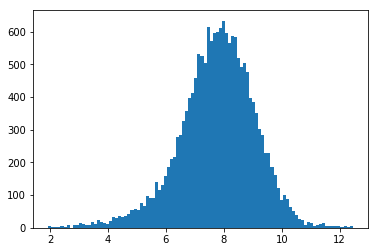

In [37]:
n, bins, patches = plt.hist(df_state24.pop_density_log2.values, bins=100)

In [38]:
df_state24.to_csv('/home/timhu/data/state24_jpgpaths_clean_17k_May17.csv')

## Test

In [3]:
# df = pd.read_csv('/home/timhu/data/all_jpgpaths_clean_538k_May14.csv')

In [17]:
# df[df.l8_vis_path.str.startswith('l8_median_india_') != True]

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
